# Setup the data

Setup and Process the data for deep learning model, this notebook includes:

- [Setup the tokenizer](#Setup-the-tokenizer)  
    1. [Download existing vocabulary](#1.-Download-existing-vocabulary)
    2. [Make changes](#2.-Make-changes)


- [Data Processing](#Data-Processing)
    1. [Load the data](#1.-Load-the-data)
    2. [Cleaning](#2.-Cleaning)
    3. [Tokenization](#3.-Tokenization)
    4. [Padding](#4.-Padding)
    5. [Saving Results](#5.-Saving-Results)

- Load dependencies

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pprint
import lorem
import random
import re
import os
import json

from transformers import BertTokenizer, GPT2Tokenizer

## Setup the tokenizer

### 1. Download existing vocabulary

We will use GPT2 Pre-trained tokenizer's vocabulary, this vocabulary contains most important words. it has about 50000 words, including special caracters.

In [2]:
def download_vocab(name="gpt2", path="./"):
    tok = GPT2Tokenizer.from_pretrained(name)
    tok.save_pretrained(path)
    os.remove(os.path.join(path, "tokenizer_config.json"))
    os.remove(os.path.join(path, "special_tokens_map.json"))
    print(f"{name} vocabulary downloaded to path: {path}")


path = "../datasets/clean/gpt2vocab"
download_vocab(path=path)

NameError: name 'GPT2Tokenizer' is not defined

### 2. Make changes

The vocabulary has so many meaningless words and irrelevant caracters. So we need to make some changes on it and reduce the vocabulary as much as we can and keep it simple to avoid comlexity later on in training phase.

**Here are a summary of the changes we will apply on the vocabulary:**
- remove irrelevant words and caracters.
- lowercase all the words.
- assign the id `1` on all non-sql words.
- Add some usefull placeholders ofr later usage, and assign and id for each.
- add special general caracters, adn assign an id for each.


**NOTE:** Some changes should be done manualy from text editor...

1. remove some irrelevant words and special caracters

In [7]:
import  re
import os
import json

src_path = "../datasets/clean/gpt2vocab/vocab.json"

# some rules to delete
regex = {
    r'^(.)\1{2,}$': "m",                                    # match repetitive letters (3 or more)
    r'-?\d+': "s",                                          # search integers
    r'\\u[0-9a-fA-F]{4}': "s",                              # search unicode caracters
    r'([@$,%^!&*)(._+\-=\[\]}{;":\\|,.<>?/~`]{2,})': "m",   # random special caracters
}

print("Regex to remove:")
print(regex)
print("="*100)

with open(src_path, "r", encoding="utf-8") as f:
    vocab = json.load(f)
    print(f"initial vocab length: {len(vocab)}")
    print("="*100)
    to_delete = []
    print("to delete:")
    for r, t in regex.items():
        if t == "m":
            for word, id in vocab.items():
                if bool(re.fullmatch(r, word)):
                    # delete word from vocab
                    to_delete.append(word)
        else:
            for word, id in vocab.items():
                if bool(re.match(r, word)):
                    # delete word from vocab
                    to_delete.append(word)
        
    print(to_delete, "\n")
    for word in set(to_delete):
        del vocab[word]
        
    print("="*100) 
    print(f"final vocab length: {len(vocab)}")
    print("="*100)

dest_path = "../utils/tokenier/vocab/vocab.json"
with open(dest_path, "w") as f:
    json.dump(vocab, f, indent=4)
    
print("done!")

Regex to remove:
{'^(.)\\1{2,}$': 'm', '-?\\d+': 's', '\\\\u[0-9a-fA-F]{4}': 's', '([@$,%^!&*)(._+\\-=\\[\\]}{;":\\\\|,.<>?/~`]{2,})': 'm'}
initial vocab length: 50257
to delete:
['!!!', '!!!!', '!!!!!', '!!!!!!!!', '"""', '###', '####', '########', '################', '################################', '$$$$', '%%%%', "''''", ')))', '))))', '***', '****', '*****', '********', '************', '****************', '********************************', '+++', '++++', '++++++++', '++++++++++++++++', ',,,,', ',,,,,,,,', '---', '----', '-----', '------', '-------', '--------', '---------', '----------', '-----------', '------------', '-------------', '--------------', '---------------', '----------------', '--------------------', '------------------------', '--------------------------------', '------------------------------------------------', '--------------------------------------------------------', '----------------------------------------------------------------', '...', '....', '.....',

2. Lowercase all words and assign the id **`1`** for each

**NOTE:** the following two cells should be run one single time

In [3]:
with open(dest_path, "r") as f:
    vocab = json.load(f)    
    print(f"initial length: {len(vocab)}")
    new_vocab = {key.lower(): 1 for key, value in vocab.items()}
    print(f"new length: {len(new_vocab)}")

with open(dest_path, "w") as f:
    json.dump(new_vocab, f, indent=4)

NameError: name 'dest_path' is not defined

3. Add some usefull plchoders for later usage, and assign an **`id`** for each

In [10]:
keywords_file_path = "../datasets/clean/keywords.txt"
vocab_file_path = "../utils/tokenier/vocab/vocab.json"

i = 1
with open(keywords_file_path, "r") as keywords_file, open(vocab_file_path, "r") as vocab_file:
    vocab = json.load(vocab_file)
    print(f"Initial vocab length: {len(vocab)}")
    for kw in keywords_file:
        vocab[kw.lower().replace("\n", "")] = i + 1
        i += 1

i -= 1
placeholders = ["<EMAIL>", "<SUB>", "<TIME>", "<DATE>", "<SERIES>", "<NUMBER>", "<REPETITIVE>", "<SINGLE>", "<REGEX>", "<SPECIAL>"]
for p in placeholders:
    vocab[p] = i + 1
    i += 1



with open(vocab_file_path, "w") as f:
    json.dump(vocab, f, indent=4)
    
print("done!")
print(f"New vocab length: {len(vocab)}")

Initial vocab length: 31557
done!
New vocab length: 31652


4. Add general caracters and assign an **`id`** for each

In [11]:
special_characters = [
    "*", "(", ")", "[", "]", "{", "}", ".", ",", ":", ";", 
    "+", "-", "=", ">", "<", "?", "/", "\\", "|", "\"", "'",
    "~", "`", "^", "%", "&", "$", "#", "@", "!", "#", "==",
    "_", "**", "^", "!=", "<=", ">="
]

i -= 1
for s in special_characters:
    vocab[s] = i + 1
    i += 1

with open(vocab_file_path, "w") as f:
    json.dump(vocab, f, indent=4)

The vocabulary is ready and it stored in the path **`vocab_file_path`**

## Data Processing

### 1. Load the data

The data was collected manually from various sources, including:
- SQL related websites
- Github repositories
- Kaggle datasets

And some of them was generated using language models, such as:
- ChatGPT
- Perplexity
- Copilot
- Gemini

Then, we assemble them all together in a text file called sqli, each query in a single line

In [6]:
with open("../datasets/clean/sqli.txt") as source:
    sqli = list(source)

#### Simple EDA

In [7]:
# preview
pprint.pprint(sqli[:5])

['SELECT * FROM Customers;\n',
 "SELECT CustomerName, Email FROM Customers WHERE City = 'Paris';\n",
 'SELECT ProductID, ProductName, Price FROM Products ORDER BY Price ASC LIMIT '
 '20;\n',
 'SELECT o.OrderID, c.CustomerName, p.ProductName FROM Orders o JOIN Customers '
 'c ON o.CustomerID = c.CustomerID JOIN Products p ON o.ProductID = '
 'p.ProductID;\n',
 'SELECT EmployeeID, FirstName, LastName, Department FROM Employees WHERE '
 "Department IN ('Engineering', 'IT');\n"]


In [9]:
print(f"number of data samples: {len(sqli)} samples")

number of data samples: 2514 samples


In [22]:
sqli_df = pd.DataFrame(sqli, columns=["query"])

def get_query_type(query):
    common_types = ["SELECT", "INSERT", "DELETE", "UPDATE", "ALTER", "DROP", "JOIN", "GROUP"]
    types = ""
    for t in common_types:
        if t in query.upper():
            types += t + "_"
    if len(types) > 0:
        return types[:-1]
    else:
        return "UNKNOWN"

sqli_df["type"] = sqli_df["query"].apply(get_query_type)
sqli_df["length"] = sqli_df["query"].apply(len)

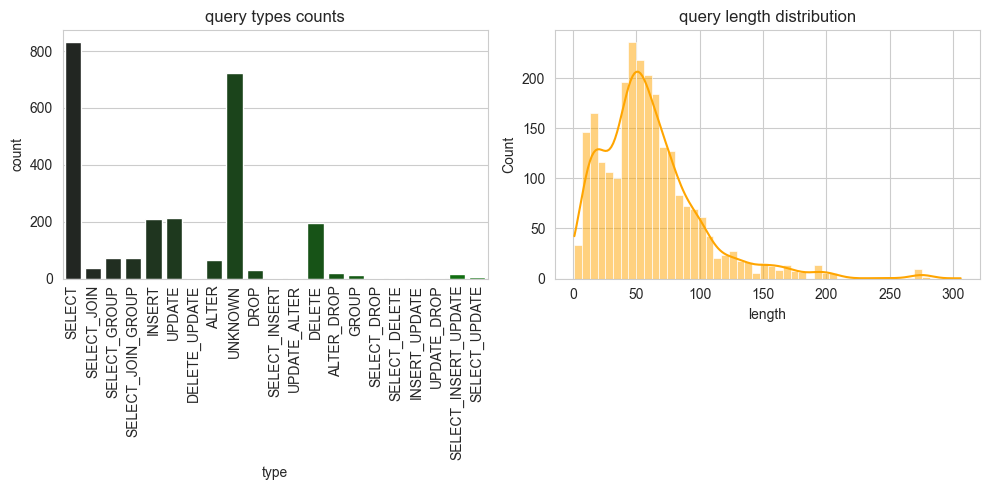

In [56]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=sqli_df, x="type", hue="type", ax=axes[0], palette="dark:green")
sns.histplot(data=sqli_df, x="length", ax=axes[1], kde=True, color="orange")

axes[0].tick_params("x", rotation=90, size=1)
axes[0].set_title("query types counts")
axes[1].set_title("query length distribution")

plt.tight_layout()
plt.show()

### 2. Cleaning

- Replace some usefull patterns with placeholders, so that same patterns will be encioded with same id later on

In [57]:
def pre_process(text):
    
    text = text.replace("\n", "")
    text = text.lower()
    text = text.strip()
    # text = text.replace(" ", "")
    
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<EMAIL>', text)
    text = re.sub(r'\b\w+(?:\.\w+)+\b', '<SUB>', text)
    text = re.sub(r'(\d+:)+\d+', '<TIME>', text)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '<DATE>', text)
    text = re.sub(r'\b(\w+)(?:,\1)+\b', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:,\d+)+\b', '<SERIES>', text)
    text = re.sub(r'\bchar\(\d+(?:\+\d+)*\)', '<SERIES>', text)
    text = re.sub(r'<SERIES>(?:\+<SERIES>)+', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\b', '<NUMBER>', text)
    text = re.sub(r'(.)\1{2,}', '<REPETITIVE>', text)
    text = re.sub(r'(?<=[@$%^!~/[\]\\` ])(?!a)\w(?=[@$%^!~/[\]\\` ])', '<SINGLE>', text)
    
    special_characters = r'[@$%^!~/[\]\-\`]'
    text = re.sub(rf'{special_characters}{{2,}}', '<REGEX>', text)
    text = re.sub(special_characters, '<SPECIAL>', text)

    text = text.replace(",", "")

    return text

In [58]:
# apply the function
sqli = list(map(pre_process, sqli))

- Shuffle the dataset

In [60]:
random.seed(123)
random.shuffle(sqli)

pprint.pprint(sqli[:5])

["' and exists(select * from users where username='admin') <REGEX>",
 'select * from products where price between <NUMBER> and <NUMBER>;',
 'select * from orders where customer_id = (select id from customers where '
 "name = 'jane doe') and order_date >= '<DATE>';",
 "<NUMBER> and substring(<REGEX>version<NUMBER>instr(<REGEX>version' "
 "'))='<SUB><SPECIAL>log'<REGEX>",
 'grant select insert update on suppliers to user4;']


### 3. Tokenization

Instantiate the tokenizer. We will use **GPT2** Pre-trained tokenizer because it has many features that are usefull for our task. such as:
- Utilizes **byte-level BPE** for tokenization, which allows it to handle a wide range of characters and languages.
- Automatically manages special tokens required by GPT-2 models, such as beginning-of-sequence (**BOS**), end-of-sequence (**EOS**), and unknown (**UNK**) tokens.
- Treats spaces as part of tokens, affecting how words are encoded based on their position in a sentence
- Can be initialized with custom vocabulary and merges files, making it adaptable for different datasets.

In [61]:
vocab_file = "../utils/tokenier/vocab/vocab.json"
merges_file = "../utils/tokenier/vocab/merges.txt"

tokenizer = GPT2Tokenizer(vocab_file=vocab_file, 
                          merges_file=merges_file,
                          unk_token="<|unk|>",
                          bos_token="<|bos|>",
                          eos_token="<|eos|>"
                         )

placeholders = ["<EMAIL>", "<SUB>", "<TIME>", "<DATE>", "<SERIES>", "<NUMBER>", "<REPETITIVE>", "<SINGLE>", "<REGEX>", "<SPECIAL>"]
special_tokens_dict = {'additional_special_tokens': placeholders}
tokenizer.add_special_tokens(special_tokens_dict)

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


0

In [62]:
def encode(data: list[str]) -> list[list[int]]:
    sequences = []
    for query in data:

        query = pre_process(query)
        tok = tokenizer.tokenize(query)
        tok = list(map(lambda x: x.replace("Ġ", ""), tok))
        tok = [item for item in tok if item != ""]
        
        for i, t in enumerate(tok):
            if bool(re.fullmatch(r'[a-zA-Z]', t)) or bool(re.fullmatch(r'-?\d+', t)):
                tok[i] = "<oov>"
        
        seq = tokenizer.convert_tokens_to_ids(tok)
        seq = [item for item in seq if item != None]
        sequences.append(seq)
    
    print("Done!")
    return sequences

In [66]:
# exmple of usage
encode(["Machine learning can ams make predictions based on data."])

Done!


[[1, 1, 1, 1, 1, 1, 1, 227, 476, 523]]

In [67]:
# apply of our dataset
sequences = encode(sqli)

Done!


### 4. Padding

First we need to determine what is the **Max Length** to use for padding (the unified length our dataset will have for each data sample)

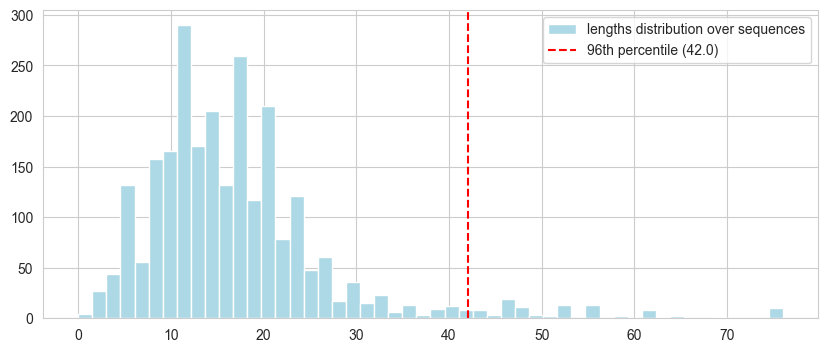

minimun length: 0
maximum length: 76
96th percentile: 42.0
above 96th percentile: 96 / 2514
below 96th percentile: 2410 / 2514
example of sequence with length 42: 
[[20397  8291 19093  3805 25625  5953 20059 25320 11334 22271   259  2545
   1988 15284 25082 17511  2548 10263 19197 25770 26230 21366 17367 11146
  28664  4333 26370  4261 16304  9483 12253 12807 23549  8520  6894 13416
  16635 18118   522 27083 28756 21988]]


In [78]:
lengths = np.array([len(item) for item in sequences])
percentile_indice = 96
percentile = np.quantile(a=lengths, q=percentile_indice/100)         # the length we used


sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(lengths, bins=50, color="lightblue", label="lengths distribution over sequences")
ax.axvline(x=percentile, linestyle="--", color="red", label=f"{percentile_indice}th percentile ({percentile})")
ax.set_xticks(np.arange(0, 75, 10))
ax.legend()
plt.show()

print(f"minimun length: {np.min(lengths)}")
print(f"maximum length: {np.max(lengths)}")
print(f"{percentile_indice}th percentile: {percentile}")
print(f"above {percentile_indice}th percentile: {sum(lengths>percentile)} / {len(lengths)}")
print(f"below {percentile_indice}th percentile: {sum(lengths<percentile)} / {len(lengths)}")

random_text = ""
while len(random_text) < percentile:
    random_text += lorem.sentence() + " "
print(f"example of sequence with length {int(percentile)}: \n{np.random.randint(0, 30000, (1, int(percentile)))}")

So we choosed the **96th** percentile as the unified length.

In [80]:
max_length = int(percentile)

Now we can apply the padding for the entier dataset (it can take some minutes to be executed...)

In [82]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences=sequences, 
                          maxlen=max_length, 
                          padding="post", 
                          truncating="post")

In [83]:
sequences = np.array(sequences)
sequences.shape

(2514, 42)

### 5. Saving Results

Our dataset is now ready for modeling ...

In [31]:
data_path = "../datasets/clean/data-numpy.npy"
np.save(data_path, sequences)